# Parse Data
Read the data out of the defect detection log, compute some basic stastitics, and store the whole thing in a Pandas dataframe

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import json

Configuration

In [ ]:
target_dir = Path('../realtime-defect/runs/drift-corrected-625C/frames/')

## List the contents of the data directory
To see what we're working with

In [ ]:
data = pd.read_json(target_dir / 'masks/defect-details.json', lines=True)
data.head()

,void_frac,void_count,radii,radii_average,positions,run_time,created_time,completed_time,mask-path,image-path,rtt,detect_time
0,0.031015,73,"[21.76338922689847, 44.695781072596446, 10.280...",19.379575,"[[7.758064516129032, 871.9005376344086], [30.3...",3.927791,2023-04-20 12:50:41.236657,2023-04-20 12:50:54.686968,frames/masks/frame-0042.tiff,frames/frame-0042.tiff,4.028447,2023-04-20 12:50:50.655216
1,0.035767,89,"[25.003212122944625, 9.83698151873187, 47.0413...",18.235661,"[[8.657841140529532, 870.8207739307536], [7.36...",0.337268,2023-04-20 12:50:41.292657,2023-04-20 12:50:55.093086,frames/masks/frame-0141.tiff,frames/frame-0141.tiff,4.437711,2023-04-20 12:50:50.655234
2,0.030486,64,"[21.996159369293583, 45.626161964841955, 46.90...",20.572885,"[[7.907894736842105, 871.771052631579], [30.34...",0.326497,2023-04-20 12:50:41.244657,2023-04-20 12:50:55.427031,frames/masks/frame-0053.tiff,frames/frame-0053.tiff,4.771642,2023-04-20 12:50:50.655242
3,0.044433,109,"[12.412170838050638, 29.618609797263055, 52.33...",18.009859,"[[6.380165289256198, 686.3388429752066], [10.1...",0.326714,2023-04-20 12:50:41.392657,2023-04-20 12:50:55.760844,frames/masks/frame-0321.tiff,frames/frame-0321.tiff,5.105455,2023-04-20 12:50:50.655249
4,0.035229,93,"[24.514670406003766, 9.640875829802336, 46.469...",17.925063,"[[8.567796610169491, 872.1334745762712], [6.06...",0.342376,2023-04-20 12:50:41.272657,2023-04-20 12:50:56.110303,frames/masks/frame-0104.tiff,frames/frame-0104.tiff,5.454884,2023-04-20 12:50:50.655255


Sort data by filename to assign `frame_ids`

In [ ]:
data['filename'] = data['image-path'].apply(lambda x: Path(x).name)
data.sort_values('filename', inplace=True)
data['frame_id'] = range(len(data))

In [ ]:
data[['void_frac', 'filename', 'completed_time', 'frame_id']]

,void_frac,filename,completed_time,frame_id
22,0.027991,frame-0000.tiff,2023-04-20 12:51:02.126679,0
298,0.029202,frame-0001.tiff,2023-04-20 12:52:33.934047,1
160,0.028360,frame-0002.tiff,2023-04-20 12:51:48.512501,2
61,0.028380,frame-0003.tiff,2023-04-20 12:51:15.298066,3
172,0.028582,frame-0004.tiff,2023-04-20 12:51:52.483045,4
...,...,...,...,...
122,0.046529,frame-0334.tiff,2023-04-20 12:51:35.728281,334
135,0.046438,frame-0335.tiff,2023-04-20 12:51:40.148597,335
132,0.047451,frame-0336.tiff,2023-04-20 12:51:39.160125,336
32,0.045900,frame-0337.tiff,2023-04-20 12:51:05.425938,337


We now have the void fractions sorted by data 

## Compute Statistics for Each Step
We want key statistics about the voids:
- Void Count
- Void Radius: Total, Mean, Standard Deviation
- Void Volume: Total, Mean, Standard Deviation
- Void Surface Area: Total, Mean, Standard Deviation
- Void Fraction

In [ ]:
def compute_stats(radii: np.ndarray) -> dict:
    """Compute some statistics about void sizes"""
    
    # Compute the surface areas and volumes
    surf_areas = 4 * np.pi * np.power(radii, 2)
    volumes = 4 / 3 * np.pi * np.power(radii, 3)
    
    # Initialize the output
    output = {'void_count': len(radii)}
    
    # Compute some statistics
    for name, values in zip(['radius', 'surfarea', 'volume'],
                           [radii, surf_areas, volumes]):
        output[f'{name}_total'] = np.sum(values)
        output[f'{name}_mean'] = np.mean(values)
        output[f'{name}_stddev'] = np.std(values)
    return output

In [ ]:
stats = pd.DataFrame(data['radii'].apply(compute_stats).tolist())
data = pd.concat((data, stats), axis=1)
data.head(3)

,void_frac,void_count,radii,radii_average,positions,run_time,created_time,completed_time,mask-path,image-path,...,void_count,radius_total,radius_mean,radius_stddev,surfarea_total,surfarea_mean,surfarea_stddev,volume_total,volume_mean,volume_stddev
22,0.027991,63,"[8.667244841319219, 21.11004122822376, 43.2038...",20.234154,"[[3.76271186440678, 745.3389830508474], [7.582...",0.324121,2023-04-20 12:50:41.216657,2023-04-20 12:51:02.126679,frames/masks/frame-0000.tiff,frames/frame-0000.tiff,...,83,1486.069423,17.904451,13.188573,515776.0,6214.168675,9140.557623,6.372895e+06,76781.870326,147487.030574
298,0.029202,76,"[21.587164551489145, 42.937755656025104, 9.507...",18.648929,"[[7.816939890710382, 870.9972677595629], [30.9...",0.313058,2023-04-20 12:50:41.216657,2023-04-20 12:52:33.934047,frames/masks/frame-0001.tiff,frames/frame-0001.tiff,...,119,2062.503204,17.331960,14.243426,752592.0,6324.302521,11156.043335,1.058999e+07,88991.511747,204295.845979
160,0.028360,73,"[11.562445770562215, 20.590987552733093, 43.05...",18.463065,"[[6.133333333333334, 682.5619047619048], [7.34...",0.318193,2023-04-20 12:50:41.216657,2023-04-20 12:51:48.512501,frames/masks/frame-0002.tiff,frames/frame-0002.tiff,...,94,1683.445476,17.908994,14.269280,619376.0,6589.106383,10576.631124,8.382104e+06,89171.319668,182706.586790


## Make Diagnostic Plots
See if everything looks fine

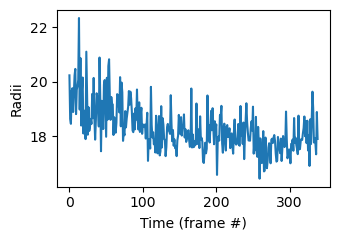

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(data['frame_id'], data['radii_average'])

ax.set_xlabel('Time (frame #)')
ax.set_ylabel('Radii')

fig.tight_layout()

## Save the data

Save the data without the raw counts to CSV, full thing as a pickle

In [ ]:
Path('datasets').mkdir(exist_ok=True)

In [ ]:
data.drop(columns=['radii']).to_csv('datasets/initial_data.csv', index=False)

In [ ]:
data.to_pickle('datasets/initial_data.pkl')